In [3]:
# Import libraries and set desired options
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV, cross_val_score

import os
from sklearn.preprocessing import OneHotEncoder
import datetime


In [4]:
data_dir = 'data/titanic/'
print(os.listdir(data_dir))

train_file = data_dir + 'train.csv'
test_file = data_dir + 'test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

['gender_submission.csv', 'test.csv', 'train.csv']


In [14]:
# function to make submission csv file with predicted values
def make_submission_file(y_pred, path='output/submissions/'):
    df = pd.DataFrame({'PassengerId': df_test['PassengerId'].values, 
                      'Survived': y_pred})
    file = path + 'sub1_{}.csv'.format(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
    df.to_csv(file, index=False)

**Data understanding**

In [143]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [144]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

In [145]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [146]:
df_train[df_train['SibSp']==8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [147]:
df_test[df_test['Name'].str.contains('Sage,')]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
188,1080,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S
342,1234,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S
365,1257,3,"Sage, Mrs. John (Annie Bullen)",female,NaN,1,9,CA. 2343,69.55,NaN,S


**Observations**
- missing value in column Age (177/891), Cabin (687/891) and Embarked (2/891)
- PassengerId seems to be randomly distributed, which is not useful
- It happens that multiple passengers share one ticket
- We might be able to dig out more information by tranforming features: Name, SibSp and Parch  

**Some hypothesis**
- Pclass, Fare, Sex, Age can be good features because people of a particular group can have better chance of survival than others
- SibSp, Parch might give additional information
- Ticket: people share the same ticket might have similar chance of survival
- Cabin: people in the same Cabin might have similar chance of survival; however, this feature has a lot of missing data

## EDA

Let's perform some exploratory analysis on the data. 

**Univariate analysis**

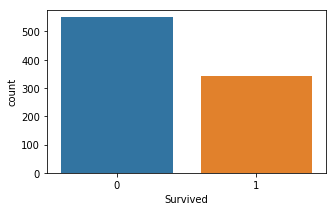

In [179]:
plt.subplots(1,1,figsize=(5,3))
sns.countplot(df_train['Survived'])

- Seems to be a balanced dataset. In this exercise, it is unclear which accuracy score is better. 

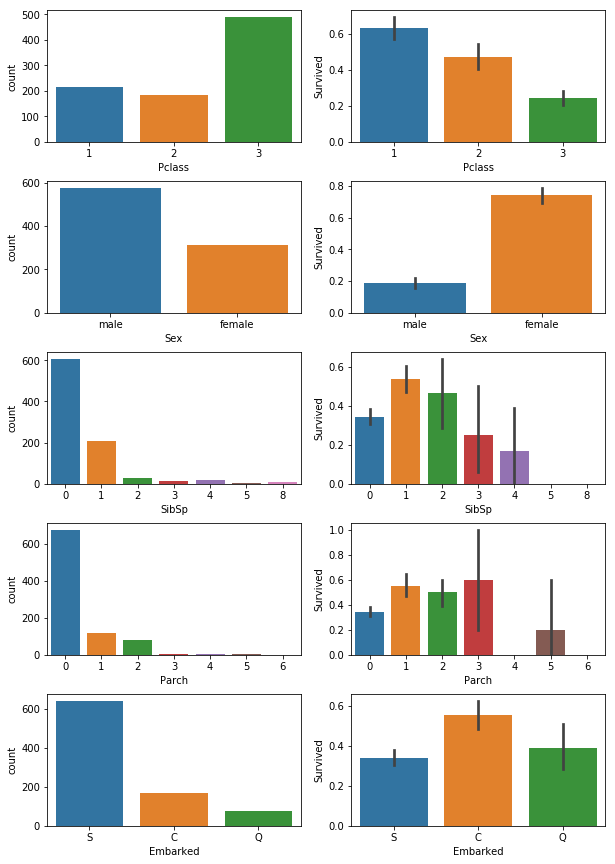

In [237]:
# start with categorical variables
cat_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

fig, axes = plt.subplots(len(cat_cols), 2, figsize=(10, 3 * len(cat_cols)))
plt.subplots_adjust(hspace=0.3)

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_train, ax=axes[i, 0])
    sns.barplot(x=col, y='Survived', data=df_train, ax=axes[i, 1])

**Observations**
- higher class and femail passengers have higher chance of survival
- passengers with one or more family members seem to have higher chance of survival
- the sample size of people have two or more SibSp or three or more Parch is too small. Maybe it would be better to merge them into one category. 

**Take a closer look at Pclass and Sex combined.**

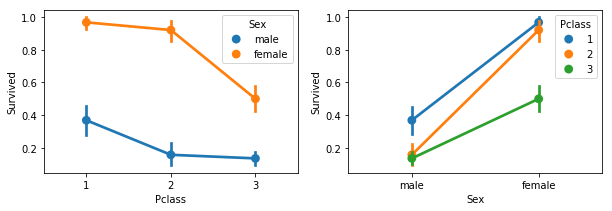

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.pointplot(x='Pclass', y='Survived', data=df_train, hue='Sex', ax=axes[0])
sns.pointplot(x='Sex', y='Survived', data=df_train, hue='Pclass', ax=axes[1])

- In all three classes, female had a higher survival rate than male, whereas in 3rd class the difference is much lower.
- The survival rates of female in 1st and 2nd class are at a similarly high level (above 90%)
- The survival rates of male in 2nd and 3rd class are at a similarly low level (around 10%)

**How about Age and Fare?**

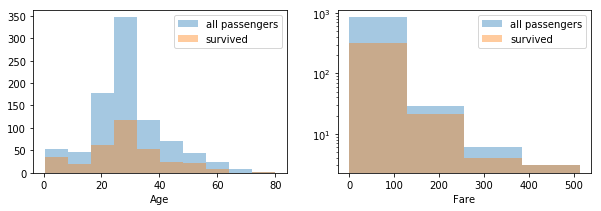

In [152]:
# distribution plot of Age by Survived
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.distplot(df_train['Age'].dropna(axis=0), ax=axes[0], hist_kws={'alpha': 0.4}, label='all passengers', kde=False, bins=10)
sns.distplot(df_train[df_train['Survived']==1]['Age'].dropna(axis=0), ax=axes[0], hist_kws={'alpha': 0.4}, label='survived', kde=False, bins=10)
axes[0].legend()

sns.distplot(df_train['Fare'].dropna(axis=0), ax=axes[1], hist_kws={'alpha': 0.4}, label='all passengers', kde=False, bins=4)
sns.distplot(df_train[df_train['Survived']==1]['Fare'].dropna(axis=0), ax=axes[1], hist_kws={'alpha': 0.4}, label='survived', kde=False, bins=4)
axes[1].legend()
axes[1].set_yscale('log')

- Passengers below 5 year old had higher much chance of survival
- Passengers who paid a higher price tend to have higher chance of survival

## Data cleaning and feature engineering

- deal with missing data
- feature transformation

In [6]:
# missing value in column Age (177/891), Cabin (687/891) and Embarked (2/891)
data_dir = 'data/titanic/'
print(os.listdir(data_dir))

train_file = data_dir + 'train.csv'
test_file = data_dir + 'test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

def clean_df(df):
    df['Age'] = df['Age'].fillna(df_train['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df_train['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df_train['Fare'].median())
    return df
    
df_train = clean_df(df_train)
df_test = clean_df(df_test)
df_train.describe(include='all')

['gender_submission.csv', 'test.csv', 'train.csv']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,204,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Canavan, Miss. Mary",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,646
mean,446.000000,0.383838,2.308642,NaN,NaN,29.361582,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,13.019697,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Baseline model

We start with a simple logistic model with features Pclass, Sex, Embarked, Age, SibSp, Parch, Fare. 

Before applying the model, we need to transform categorical variables using One-Hot-Encoding. Also we use StandardScaler to see feature significance.

In [295]:
cat_features = ['Pclass', 'Sex', 'Embarked']
num_features = ['Age', 'SibSp', 'Parch', 'Fare']


ohe = OneHotEncoder(categories='auto', drop='first', sparse=False)
scaler = StandardScaler()

X_train = np.hstack((ohe.fit_transform(df_train[cat_features]), df_train[num_features]))
y_train = df_train['Survived'].values
X_test = np.hstack((ohe.transform(df_test[cat_features]), df_test[num_features]))

features = list(ohe.get_feature_names(cat_features)) + num_features

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, y_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape, features

((891, 9),
 (891,),
 (418, 9),
 (891, 9),
 (418, 9),
 ['Pclass_2',
  'Pclass_3',
  'Sex_male',
  'Embarked_Q',
  'Embarked_S',
  'Age',
  'SibSp',
  'Parch',
  'Fare'])

In [311]:
%%time

model = LogisticRegression(random_state=100, C=1.0)  # default C = 1.0

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance
df_feature = pd.DataFrame({'coef1': model.coef_[0], 'abs_coef1': abs(model.coef_[0])}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
cv_score: 0.7901868119826072 0.021227380282388637
feature importance:
                coef1  abs_coef1
Sex_male   -1.282124   1.282124
Pclass_3   -1.036406   1.036406
Age        -0.486679   0.486679
Pclass_2   -0.351708   0.351708
SibSp      -0.346460   0.346460
Embarked_S -0.194209   0.194209
Fare        0.126957   0.126957
Parch      -0.074927   0.074927
Embarked_Q -0.017280   0.017280
CPU times: user 22.5 ms, sys: 2.5 ms, total: 25 ms
Wall time: 47.4 ms


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We can see that top features are Sex, Pclass and Age, as we expected.

**Logit with GridSearchCV on C**

In [312]:
%%time

param = {'C': np.logspace(-2, 1, 20)}

gs = GridSearchCV(LogisticRegression(random_state=100, solver='lbfgs'),
                     param_grid=param,
                     cv=5,
                     n_jobs=-1,
                     verbose=True
                    )

gs.fit(X_train_scaled, y_train)


model = gs.best_estimator_

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance
df_feature = pd.DataFrame({'coef1': model.coef_[0], 'abs_coef1': abs(model.coef_[0])}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
cv_score: 0.8036133934939057 0.016412650116930515
feature importance:
                coef1  abs_coef1
Sex_male   -0.725512   0.725512
Pclass_3   -0.397591   0.397591
Fare        0.208973   0.208973
Age        -0.167667   0.167667
Embarked_S -0.152055   0.152055
SibSp      -0.131399   0.131399
Embarked_Q -0.007896   0.007896
Parch      -0.003462   0.003462
Pclass_2   -0.002303   0.002303
CPU times: user 92.7 ms, sys: 847 µs, total: 93.6 ms
Wall time: 309 ms


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


PL score of 0.76076 is an improvement from the previous submission of 0.75598. As expected, applying a higher regularization (smaller C) helps with the predictive power of the model. 

Same as default Logit model, we can see that top features are Sex and Pclass, then comes Fare, Age, Embarked_S, SibSp.

**Random Forest**

In [316]:
# try default setting
model = RandomForestClassifier(n_estimators=100, random_state=100)

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance
df_feature = pd.DataFrame({'coef1': model.feature_importances_, 'abs_coef1': abs(model.feature_importances_)}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)
cv_score: 0.8159918461926381 0.028577270144081176
feature importance:
                coef1  abs_coef1
Fare        0.267395   0.267395
Sex_male    0.264018   0.264018
Age         0.263066   0.263066
Pclass_3    0.070087   0.070087
SibSp       0.045951   0.045951
Parch       0.038514   0.038514
Embarked_S  0.022835   0.022835
Pclass_2    0.017918   0.017918
Embarked_Q  0.010216   0.010216


Now RF with parameters tuning

In [322]:
%%time

param = { 'n_estimators': np.linspace(10, 100, 5).astype(int),
#             'max_features': [4, 7, 10, 13], 
              'min_samples_leaf': [1, 3, 5, 7], 
              'min_samples_split':[5, 10, 20],
              'max_depth': [5, 10, 15, 20]
        }


gs = GridSearchCV(RandomForestClassifier(random_state=100),
                     param_grid=param,
                     cv=5,
                     n_jobs=-1,
                     verbose=True
                    )

gs.fit(X_train_scaled, y_train)

model = gs.best_estimator_

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance
df_feature = pd.DataFrame({'coef1': model.feature_importances_, 'abs_coef1': abs(model.feature_importances_)}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)
cv_score: 0.8350807702851315 0.025340947497630814
feature importance:
                coef1  abs_coef1
Sex_male    0.384074   0.384074
Fare        0.237656   0.237656
Age         0.161750   0.161750
Pclass_3    0.090710   0.090710
SibSp       0.043568   0.043568
Parch       0.031326   0.031326
Embarked_S  0.021969   0.021969
Pclass_2    0.021439   0.021439
Embarked_Q  0.007509   0.007509
CPU times: user 1.9 s, sys: 47.9 ms, total: 1.94 s
Wall time: 1min 16s


PL score 0.76555

RF result is a bit higher than Logit but comes with higher stdev

From the RF model, we can see that Fare replaced Pclass as a more significant feature. One explaination can be potential correlation between Pclass and Fare. **We might consider some feature transformation on Fare**

**KNN**

In [326]:
%%time

param = {'n_neighbors': np.linspace(2, 50, 10).astype(int)}

gs = GridSearchCV(KNeighborsClassifier(),
                     param_grid=param,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1,
                     verbose=True
                    )

gs.fit(X_train_scaled, y_train)

model = gs.best_estimator_

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance-> no feature importance for KNN
# df_feature = pd.DataFrame({'coef1': model.feature_importances_, 'abs_coef1': abs(model.feature_importances_)}, index=features).sort_values('abs_coef1', ascending=False)
# print("feature importance:\n", df_feature)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=28, p=2,
                     weights='uniform')
cv_score: 0.8058668615750056 0.014030389791597979
CPU times: user 85.2 ms, sys: 366 µs, total: 85.6 ms
Wall time: 259 ms


PL score: 0.76555, so far the highest score.

**XGBOOST**


In [328]:
%%time

# fit model no training data
model = XGBClassifier()

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance-> no feature importance for KNN
df_feature = pd.DataFrame({'coef1': model.feature_importances_, 'abs_coef1': abs(model.feature_importances_)}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
cv_score: 0.826079310245774 0.016621056984328825
feature importance:
                coef1  abs_coef1
Sex_male    0.543216   0.543216
Pclass_3    0.211208   0.211208
SibSp       0.058878   0.058878
Embarked_S  0.055549   0.055549
Fare        0.041465   0.041465
Age         0.034435   0.034435
Pclass_2    0.026812   0.026812
Embarked_Q  0.015238   0.015238
Parch       0.013199   0.013199
CPU times: user 73.5 ms, sys: 2.39 ms, total: 75.9 ms
Wall time: 216 ms


Most important features are Sex and PClass!

## More Feature Engineering

In order to improve performance, we should try more feature engineering rather than tuning Models. 
We get some ideas from this [blog](https://zhuanlan.zhihu.com/p/31743196).

- Cabin data  -> Cabin section + number
- Binning Age
- Extract Name Title, Name length
- Log transfor Fare
- Consider keep Pclass as numerical

**Used Spyder for this part of coding**

In [216]:
# see data_cleaning.py

# Another round of modeling 

using data with new features

In [8]:
# load cleaned data
df_train = pd.read_csv('data/df_train_clean.csv')
df_test = pd.read_csv('data/df_test_clean.csv')

In [9]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'cabin_section',
       'cabin_number', 'Age_group', 'Fare_log', 'Fare_zero', 'name_len',
       'name_title', 'name_title_Master.', 'name_title_Don.',
       'name_title_Rev.', 'name_title_Dr.', 'name_title_Mme.',
       'name_title_Major.', 'name_title_Lady.', 'name_title_Sir.',
       'name_title_Mlle.', 'name_title_Col.', 'name_title_Capt.', 'family'],
      dtype='object')

In [10]:
# select features and transformation

cat_features = ['Pclass', 'Sex', 'Embarked', 'Age_group', ]
name_title_cols = ['name_title_Master.', 'name_title_Don.', 'name_title_Rev.',
                   'name_title_Dr.', 'name_title_Mme.', 'name_title_Major.',
                   'name_title_Lady.', 'name_title_Sir.', 'name_title_Mlle.',
                   'name_title_Col.', 'name_title_Capt.']
# num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare_log', 'cabin_number', 'name_len'] + name_title_cols
num_features = ['cabin_section', 'family', 'Fare_log', 'Fare_zero',  'name_title_Master.', 'name_title_Col.', 'name_title_Capt.', 'name_title_Don.', 'name_title_Rev.',
                   'name_title_Dr.', 'name_title_Major.'] 


ohe = OneHotEncoder(categories='auto', drop='first', sparse=False)
scaler = StandardScaler()

X_train = np.hstack((ohe.fit_transform(df_train[cat_features]), df_train[num_features]))
y_train = df_train['Survived'].values
X_test = np.hstack((ohe.transform(df_test[cat_features]), df_test[num_features]))

features = ohe.get_feature_names(cat_features).tolist() + num_features

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, y_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape, features

((891, 18),
 (891,),
 (418, 18),
 (891, 18),
 (418, 18),
 ['Pclass_2',
  'Pclass_3',
  'Sex_male',
  'Embarked_Q',
  'Embarked_S',
  'Age_group_kid (0-6)',
  'Age_group_teenager (6-18)',
  'cabin_section',
  'family',
  'Fare_log',
  'Fare_zero',
  'name_title_Master.',
  'name_title_Col.',
  'name_title_Capt.',
  'name_title_Don.',
  'name_title_Rev.',
  'name_title_Dr.',
  'name_title_Major.'])

**Logit**

In [22]:
%%time

param = {'C': np.logspace(-2, 1, 20)}

gs = GridSearchCV(LogisticRegression(random_state=100, solver='lbfgs'),
                     param_grid=param,
                     cv=5,
                     n_jobs=-1,
                     verbose=True
                    )

gs.fit(X_train_scaled, y_train)

model = gs.best_estimator_

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance
df_feature = pd.DataFrame({'coef1': model.coef_[0], 'abs_coef1': abs(model.coef_[0])}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
cv_score: 0.828326643111696 0.017928002491150077
feature importance:
                               coef1  abs_coef1
Sex_male                  -1.318214   1.318214
family                    -0.581455   0.581455
name_title_Master.         0.534688   0.534688
Pclass_3                  -0.399721   0.399721
cabin_section              0.329659   0.329659
Fare_log                   0.288083   0.288083
Embarked_S                -0.194098   0.194098
name_title_Rev.           -0.183102   0.183102
Age_group_kid (0-6)        0.151532   0.151532
name_title_Don.           -0.087428   0.087428
name_title_Capt.          -0.085068   0.085068
Age_group_teenager (6-18)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


**RF**

In [336]:
%%time

param = { 'n_estimators': np.linspace(10, 100, 5).astype(int),
#             'max_features': [4, 7, 10, 13], 
              'min_samples_leaf': [1, 3, 5, 7], 
              'min_samples_split':[5, 10, 20],
              'max_depth': [5, 10, 15, 20]
        }


gs = GridSearchCV(RandomForestClassifier(random_state=100),
                     param_grid=param,
                     cv=5,
                     n_jobs=-1,
                     verbose=True
                    )

gs.fit(X_train_scaled, y_train)

model = gs.best_estimator_

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
print(model)
print("cv_score:", cv_score.mean(), cv_score.std())  

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  
# make_submission_file(y_pred=y_pred)

# feature importance
df_feature = pd.DataFrame({'coef1': model.feature_importances_, 'abs_coef1': abs(model.feature_importances_)}, index=features).sort_values('abs_coef1', ascending=False)
print("feature importance:\n", df_feature)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1006 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.5min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=77,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)
cv_score: 0.8306367466762561 0.03482526029669744
feature importance:
                               coef1  abs_coef1
Sex_male                   0.402871   0.402871
Fare_log                   0.211081   0.211081
Pclass_3                   0.089309   0.089309
family                     0.081970   0.081970
cabin_section              0.067919   0.067919
Age_group_kid (0-6)        0.028566   0.028566
name_title_Master.         0.027894   0.027894
Embarked_S                 0.026190   0.026190
Pclass_2           

**Selecting only top N features to migigate overfitting**

In [25]:
top_features = df_feature.head(10).index.values
X_train_scaled_top = pd.DataFrame(X_train_scaled, columns=features)[top_features].values
X_test_scaled_top = pd.DataFrame(X_test_scaled, columns=features)[top_features].values

In [26]:
%%time

# fit model no training data
model = LogisticRegression(C=0.12)

cv_score = cross_val_score(model, X_train_scaled_top, y_train, cv=5, n_jobs=-1)
print("cv score:", cv_score.mean(), cv_score.std())   
model.fit(X_train_scaled_top, y_train)

# feature importance
# df_features_top = pd.DataFrame({'coef1': model.feature_importances_, 'abs_coef1': abs(model.feature_importances_)}, index=top_features).sort_values('abs_coef1', ascending=False)
df_features_top = pd.DataFrame({'coef1': model.coef_[0], 'abs_coef1': abs(model.coef_[0])}, index=top_features).sort_values('abs_coef1', ascending=False)

print(df_features_top)

y_pred = model.predict(X_test_scaled_top)  # ---> PL score: 0.77511!! XGBOOST is the best model as expected!
make_submission_file(y_pred=y_pred)

cv score: 0.8182645710473876 0.02343044346691317
                        coef1  abs_coef1
Sex_male            -1.368611   1.368611
family              -0.618654   0.618654
name_title_Master.   0.585241   0.585241
Pclass_3            -0.432016   0.432016
Fare_log             0.322076   0.322076
cabin_section        0.304415   0.304415
name_title_Rev.     -0.187288   0.187288
Embarked_S          -0.175229   0.175229
Age_group_kid (0-6)  0.132797   0.132797
name_title_Don.     -0.091647   0.091647
CPU times: user 57.9 ms, sys: 6.26 ms, total: 64.2 ms
Wall time: 119 ms


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
